In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import corner
import emcee
#from scipy.special import erfinv
from scipy.stats import norm, pearsonr, multivariate_normal

1.1277796896595322 0.07561281151077968
1.0786001011337767 0.06627800492017517
0.9450415208214988


Text(0.5, 0, 'Mass (M$_\\odot$)')

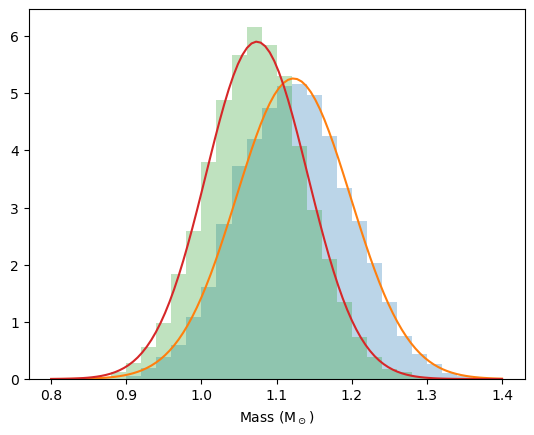

In [2]:
chain = np.load('mcmc_out/5095_chains_1.npy')
mA_mu = chain[:,5000:,11].mean()
mA_sigma = chain[:,5000:,11].std()
mB_mu = chain[:,5000:,12].mean()
mB_sigma = chain[:,5000:,12].std()
rho, _ = pearsonr(chain[:,5000:,11].flatten(), chain[:,5000:,12].flatten())
print(mA_mu, mA_sigma)
print(mB_mu, mB_sigma)
print(rho)

plt.hist(chain[...,11].flatten(), range=[0.8, 1.4], bins=30, density=True, alpha=0.3)
plt.plot(np.linspace(0.8, 1.4, 100), norm.pdf(np.linspace(0.8, 1.4, 100), chain[...,11].mean(), chain[...,11].std()))

plt.hist(chain[...,12].flatten(), range=[0.8, 1.4], bins=30, density=True, alpha=0.3)
plt.plot(np.linspace(0.8, 1.4, 100), norm.pdf(np.linspace(0.8, 1.4, 100), chain[...,12].mean(), chain[...,12].std()))
plt.xlabel('Mass (M$_\odot$)')

Text(0.5, 0, '$M_B/M_A$')

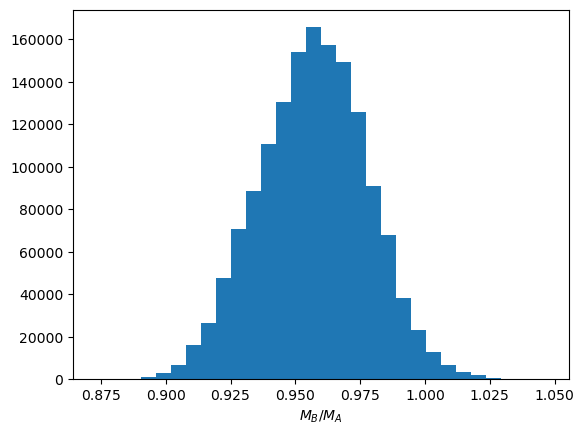

In [3]:
plt.hist((chain[:,5000:,12]/chain[:,5000:,11]).flatten(), bins=30);
plt.xlabel('$M_B/M_A$')

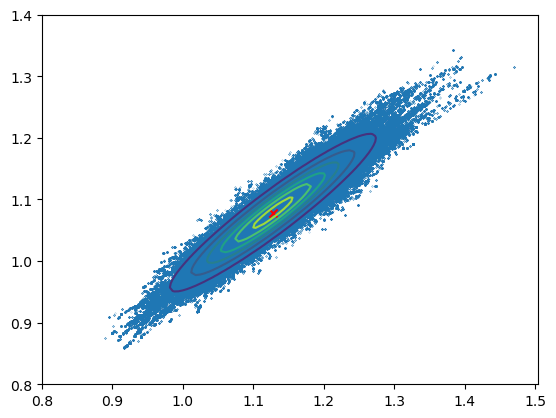

In [4]:
plt.scatter(chain[:,5000:,11].flatten(), chain[:,5000:,12].flatten(), marker='.', s=0.1)
x = np.linspace(0.8, 1.4, 100)
y = np.linspace(0.8, 1.4, 100)
plt.scatter([mA_mu], [mB_mu], marker='x', color='red')
x, y = np.meshgrid(x, y)
plt.contour(x, y, multivariate_normal(mean=[mA_mu, mB_mu], cov=np.array([[mA_sigma**2, rho*mA_sigma*mB_sigma], [rho*mA_sigma*mB_sigma, mB_sigma**2]])).pdf(np.array([x, y]).T).T)

In [5]:
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
from isochrones import get_ichrone
mist = MIST_Isochrone()

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [6]:
mags = {'G':(13.4394, np.sqrt((1.0857/5059.459)**2 + 0.002755**2)), 'BP':(13.7217, np.sqrt((1.0857/582.46)**2+0.00279**2)), 'RP':(12.9942, np.sqrt((1.0857/1167.71)**2+0.00378**2)), 
        'J':(12.499, 0.023), 'H':(12.217, 0.018), 'K':(12.215, 0.024)}
mod = StarModel(mist, **mags, N=2, parallax=(0.8126,0.0148))
mod.print_ascii()
#mod.lnlike([1.1, 1.1,8.0, 0., 1260, 0.1])

root
 ╚═  G=(13.44, 0.00) @(0.00, 0 [99.00])
    ╚═  BP=(13.72, 0.00) @(0.00, 0 [99.00])
       ╚═  RP=(12.99, 0.00) @(0.00, 0 [99.00])
          ╚═  J=(12.50, 0.02) @(0.00, 0 [99.00])
             ╚═  H=(12.22, 0.02) @(0.00, 0 [99.00])
                ╚═  K=(12.21, 0.02) @(0.00, 0 [99.00])
                   ╠═ 0_0, parallax=(0.8126, 0.0148)
                   ╚═ 0_1, parallax=(0.8126, 0.0148)


In [7]:
def mass_lnprior(p):
    return -1/(2*(1 - rho**2)) * ((p[0] - mA_mu)**2/mA_sigma**2 + (p[1] - mB_mu)**2/mB_sigma**2 
                                  - 2*rho*(p[0] - mA_mu)*(p[1] - mB_mu)/(mA_sigma*mB_sigma))

def lnpost(p):
    return mass_lnprior(p) + mod.lnprior(p) + mod.lnlike(p)

In [8]:
try:
    chain = np.load('isochrones_out/isochrones_chain.npy')
    lnprobability = np.load('isochrones_out/isochrones_lnprob.npy')
except:
    from multiprocessing import Pool
    with Pool() as pool:
        nwalkers = 50
        sampler = emcee.EnsembleSampler(nwalkers, 6, lnpost, pool=pool)
        p0 = np.array([mA_mu, mB_mu, 9.6, 0.0, 1230, 0.3]) \
            + np.array([mA_sigma, mB_sigma, 0.2, 0.05, 10, 0.05])*np.random.normal(size=(nwalkers,6))
        sampler.run_mcmc(p0, 100000);
    chain = sampler.get_chain()
    np.save('isochrones_out/isochrones_chain.npy', chain)
    lnprobability = sampler.lnprobability
    np.save('isochrones_out/isochrones_lnprob.npy', lnprobability)

In [9]:
good_walkers = lnprobability[:,-1] > -25
print(good_walkers.sum())

43


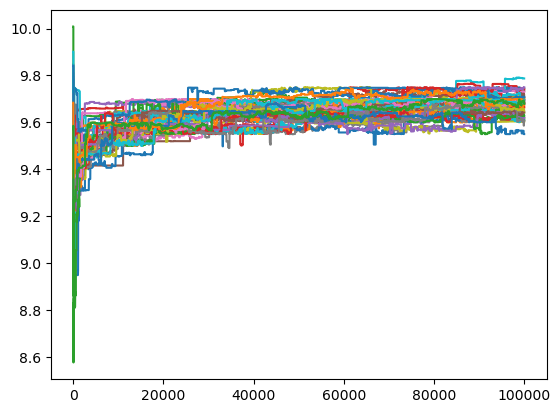

In [10]:
plt.plot(chain[:,good_walkers,2]);

In [11]:
#corner.corner(chain[20000:,good_walkers,:].reshape(-1, 6))

In [12]:
chain[20000:,good_walkers,:].reshape(-1, 6).shape

(3440000, 6)

In [13]:
chain[-1,good_walkers,3]

array([0.07210864, 0.01548968, 0.11792896, 0.01141612, 0.0889189 ,
       0.12111551, 0.09793219, 0.1280463 , 0.14688249, 0.0281671 ,
       0.07180273, 0.00438584, 0.09474778, 0.00233398, 0.08572947,
       0.00035257, 0.06555128, 0.137458  , 0.06811099, 0.16103313,
       0.02266134, 0.10609815, 0.09149529, 0.12149724, 0.12837446,
       0.01920323, 0.01438935, 0.02665425, 0.14802782, 0.10993634,
       0.03974388, 0.06490754, 0.10818086, 0.0717622 , 0.00795481,
       0.1708308 , 0.05527553, 0.14172689, 0.09723862, 0.10368257,
       0.24024639, 0.07826532, 0.1000996 ])

In [19]:
tracks = get_ichrone('mist', tracks=False)
mass, age, feh = chain[-1,good_walkers,0], chain[-1,good_walkers,2], chain[-1,good_walkers,3]
r1 = tracks.generate(mass, age, feh)['radius']
mass, age, feh = chain[-1,good_walkers,1], chain[-1,good_walkers,2], chain[-1,good_walkers,3]
r2 = tracks.generate(mass, age, feh)['radius']

In [20]:
print(r1.mean(), r1.std())
print(r2.mean(), r2.std())

1.4910544672100627 0.07172731569203906
1.2993760198279007 0.0610770899386591


In [21]:
i,j = np.unravel_index(lnprobability.argmax(), lnprobability.shape)
p0_best = chain[j,i,:]
print(p0_best)
print(lnprobability[i,j])

[1.14542719e+00 1.08275014e+00 9.74767194e+00 4.37755441e-02
 1.23330167e+03 1.30407026e-02]
-12.437173463672014


In [ ]:
# from isochrones import get_ichrone, StarModel

# mags = {'G':(13.4394, 0.0002), 'BP':(13.7217, 1/582.46), 'RP':(12.9942, 1/1167.71), 
#         'J':(12.499, 0.023), 'H':(12.217, 0.018), 'K':(12.215, 0.024)}
# mod = StarModel(mist, **mags, N=1, parallax=(0.8126*np.sqrt(2),0.0148))
# mod.set_bounds(mass=(1.0, 1.2), feh=(-0.3, 0.1))
# mod.print_ascii()

In [ ]:
#mod.fit(n_live_points=2000, resume=False)

In [ ]:
#mod.corner_physical();

In [ ]:
# from isochrones import get_ichrone, StarModel

# mags = {'G':(13.4394, 0.0002), 'BP':(13.7217, 1/582.46), 'RP':(12.9942, 1/1167.71), 
#         'J':(12.499, 0.023), 'H':(12.217, 0.018), 'K':(12.215, 0.024)}
# mod = StarModel(mist, **mags, N=2, parallax=(0.8126,0.0148))
# mod.print_ascii()

In [ ]:
# import inspect
# print(inspect.getsource(mod.set_bounds))
# mod.set_bounds(mass=(1.0, 1.2), feh=(-0.3, 0.1))

In [ ]:
#mod.fit(n_live_points=2000)

In [ ]:
#mod.corner_physical();

In [ ]:
# mags = {'G':(13.4394, 0.0002), 'BP':(13.7217, 1/582.46), 'RP':(12.9942, 1/1167.71), 
#         'J':(12.499, 0.023), 'H':(12.217, 0.018), 'K':(12.215, 0.024)}
# mod = StarModel(mist, **mags, N=2, parallax=(0.8126,0.0148))
# mod.print_ascii()

In [ ]:
# def mnest_prior_modified(self, cube, ndim, nparams):
#         for _,n in self.obs.Nstars.items():
#             #minmass, maxmass = mod.bounds('mass')
#             #for j in range(n):
#             #    cube[j] = (maxmass - minmass)*cube[j] + minmass
#             #cube[0] = np.percentile(chain[...,11], 100*cube[0])
#             #cube[1] = np.percentile(chain[...,12], 100*cube[1])
#             cube[0] = mA_mu + mA_sigma*np.sqrt(2)*erfinv(2*cube[0] - 1)
#             #cube[1] = mB_mu + mB_sigma*np.sqrt(2)*erfinv(2*cube[1] - 1)
#             cube[1] = mB_mu + rho*mB_sigma/mA_sigma * (cube[0] - mA_mu) + \
#                         np.sqrt(2)*mB_sigma*np.sqrt(1 - rho**2) * erfinv(2*cube[1] - 1)

#             for j, par in enumerate(['age','feh','distance','AV']):
#                 lo, hi = self.bounds(par)
#                 cube[n+j] = (hi - lo)*cube[n+j] + lo

# mod.mnest_prior = types.MethodType(mnest_prior_modified, mod)

In [ ]:
# import logging
# def lnprior_modified(self, p):
#     N = self.obs.Nstars
#     i = 0
#     lnp = 0
#     for s in self.obs.systems:
#         age, feh, dist, AV = p[i+N[s]:i+N[s]+4]
#         for prop, val in zip(['age','feh','distance','AV'],
#                              [age, feh, dist, AV]):
#             lo,hi = self.bounds(prop)
#             if val < lo or val > hi:
#                 return -np.inf
#             lnp += np.log(self.prior(prop, val))
#             if not np.isfinite(lnp):
#                 logging.debug('lnp=-inf for {}={} (system {})'.format(prop,val,s))
#                 return -np.inf

#         masses = p[i:i+N[s]]

#         # Mass prior for primary
#         #lnp += np.log(self.prior('mass', masses[0]))
#         lnp += -1/(2*(1 - rho**2)) * ((masses[0] - mA_mu)**2/mA_sigma**2 + (masses[1] - mB_mu)**2/mB_sigma**2 -\
#                                       2*rho*(masses[0] - mA_mu)*(masses[1] - mB_mu)/(mA_sigma*mB_sigma))
#         if not np.isfinite(lnp):
#             logging.debug('lnp=-inf for mass={} (system {})'.format(masses[0],s))

#         i += N[s] + 4

#     return lnp

# mod.lnprior = types.MethodType(lnprior_modified, mod)